In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np 
import pandas as pd 
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [2]:
df = pd.read_csv(r"C:\Users\Aryan Shukla\Downloads\archive\full_df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [3]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [4]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [5]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [6]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [7]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [8]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [9]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [10]:
print(len(cataract),len(normal))

594 500


In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = r"C:\Users\Aryan Shukla\Downloads\archive\preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(cataract,1)

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:01<00:00, 341.35it/s]


In [13]:
len(dataset)

588

In [14]:
dataset = create_dataset(normal,0)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 264.93it/s]


In [15]:
len(dataset)

1088

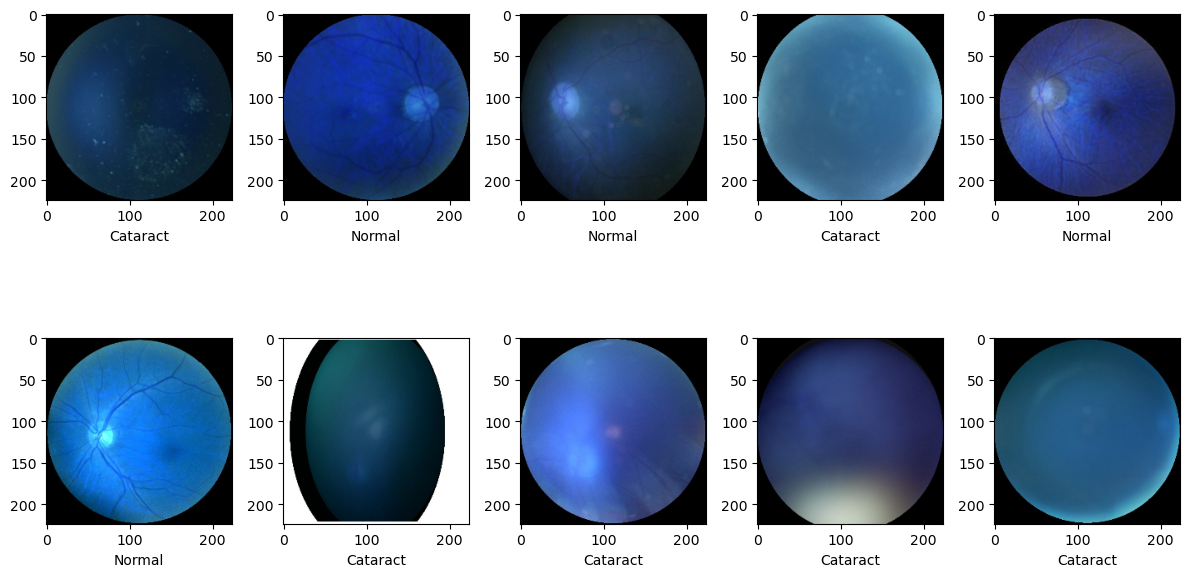

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()    

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [18]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

class_counts = df['C'].value_counts()
print("Total Jumlah Dataset Yang Digunakan:", len(x))

normal_train_count = (y_train == 0).sum()
cataract_train_count = (y_train == 1).sum()

normal_test_count = (y_test == 0).sum()
cataract_test_count = (y_test == 1).sum()

print("\nJumlah sampel 'Normal' dalam data training:", normal_train_count)
print("Jumlah sampel 'Cataract' dalam data training:", cataract_train_count)

print("\nJumlah sampel 'Normal' dalam data testing:", normal_test_count)
print("Jumlah sampel 'Cataract' dalam data testing:", cataract_test_count)

Total Jumlah Dataset Yang Digunakan: 1088

Jumlah sampel 'Normal' dalam data training: 399
Jumlah sampel 'Cataract' dalam data training: 471

Jumlah sampel 'Normal' dalam data testing: 101
Jumlah sampel 'Cataract' dalam data testing: 117


In [21]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

In [22]:
for layer in vgg.layers:
    layer.trainable = False

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ ?                           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [25]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.keras", monitor="val_acc", verbose=1,
                             save_best_only=True, save_weights_only=False)
earlystop = EarlyStopping(monitor="val_acc", patience=5, verbose=1, mode='max')


In [32]:
history = model.fit(x_train, y_train, batch_size=64, epochs=25,
                    validation_data=(x_test, y_test), verbose=1,
                    callbacks=[checkpoint, earlystop])


Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 106s 7s/step - accuracy: 0.9747 - loss: 0.1551 - val_accuracy: 0.9587 - val_loss: 0.2203
Epoch 2/25


D:\Anaconda\Lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 94s 7s/step - accuracy: 0.9896 - loss: 0.0407 - val_accuracy: 0.9633 - val_loss: 0.2431
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 92s 7s/step - accuracy: 0.9994 - loss: 0.0029 - val_accuracy: 0.9679 - val_loss: 0.2018
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9679 - val_loss: 0.2270
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 93s 7s/step - accuracy: 1.0000 - loss: 5.4130e-04 - val_accuracy: 0.9679 - val_loss: 0.2224
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 163s 12s/step - accuracy: 1.0000 - loss: 1.9912e-04 - val_accuracy: 0.9633 - val_loss: 0.2280
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 165s 12s/step - accuracy: 1.0000 - loss: 1.2329e-04 - val_accuracy: 0.9679 - val_loss: 0.2123
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 163s 12s/step - accuracy: 1.0000 - loss: 1.1012e-04 - val_accuracy: 0.9679 - val_loss: 0.2041
Epoch 9/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 165s 12s/step - accuracy: 1.0000 - loss: 1.1080e-04 - val_accuracy: 0

In [33]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.9685 - loss: 0.1513
loss: 0.21584776043891907
Accuracy: 0.9678899049758911


In [34]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


In [35]:
accuracy_score(y_test,y_pred)
precision_score(y_test, y_pred)
recall_score(y_test, y_pred)
f1_score(y_test,y_pred)

0.9707112970711297

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       101
           1       0.95      0.99      0.97       117

    accuracy                           0.97       218
   macro avg       0.97      0.97      0.97       218
weighted avg       0.97      0.97      0.97       218



In [38]:
pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 2.1 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.4 MB 2.0 MB/s eta 0:00:01
   ------- -------------------------------- 0.3/1.4 MB 2.2 MB/s eta 0:00:01
   --------- ------------------------------ 0.4/1.4 MB 1.9 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.4 MB 1.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.5/1.4 MB 1.7 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 1.7 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.4 MB 1.6 MB/s eta 0:00:01
   ------------------ --------------------- 0.7/1.4 MB 1.5 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.4 MB 1.6 MB/s eta 0:00:01
   --------------------- ------------------ 0.8/1.4 MB 1.6 MB/s eta 0:00:01
   -----------------------

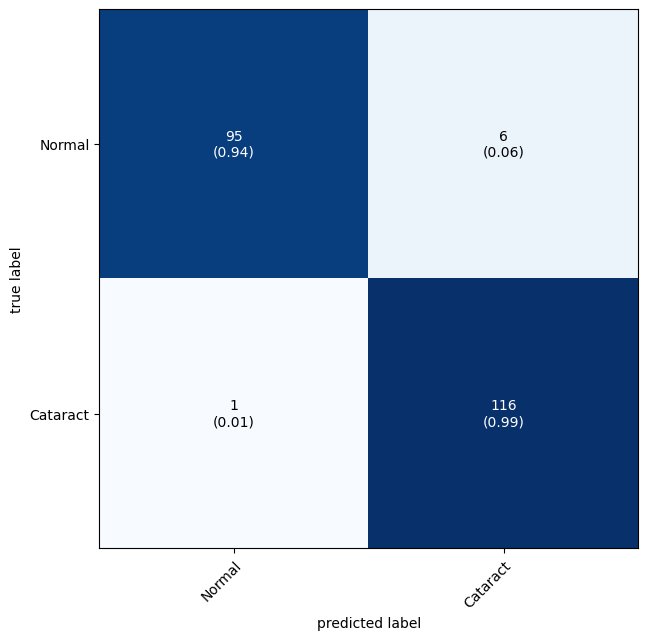

In [39]:
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Cataract"],
                      show_normed = True);

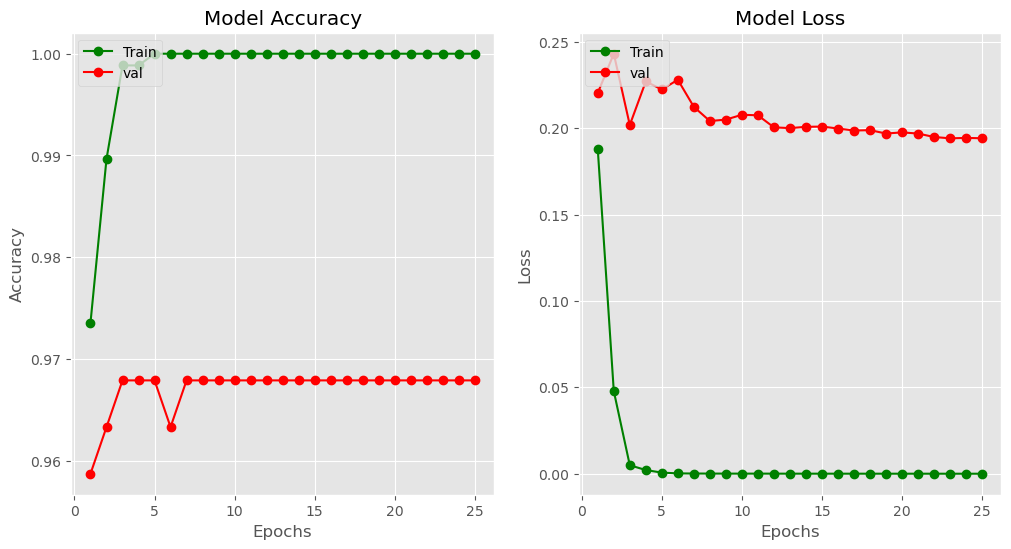

In [40]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,26)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

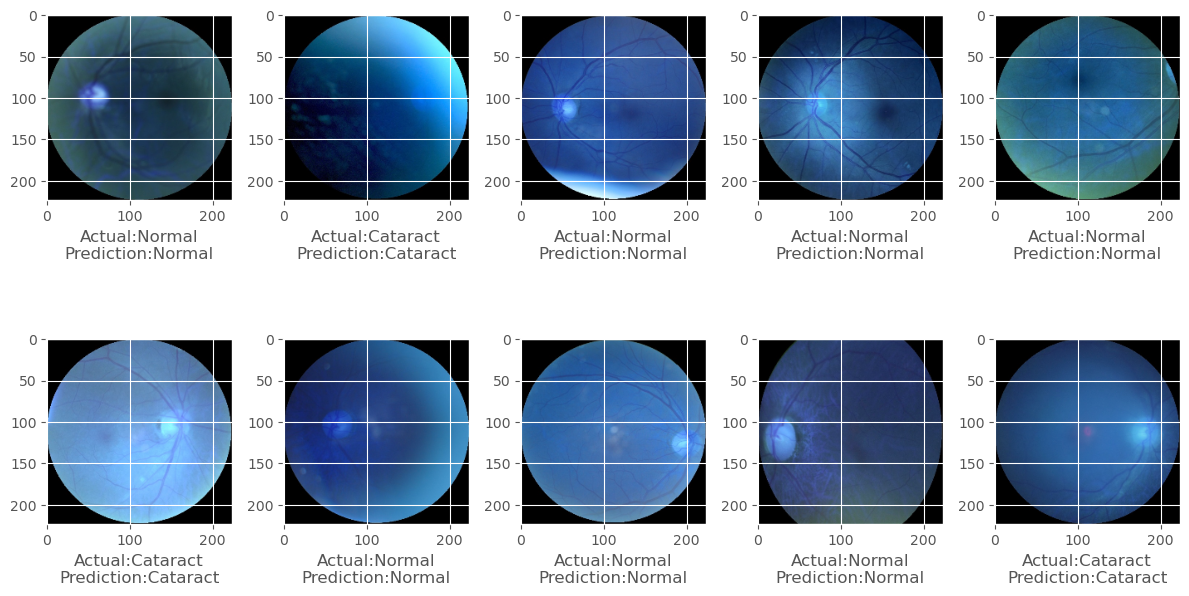

In [41]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Cataract"
        
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 